# Quick start

In this notebook, we build a simple workflow using three column operations: link, calculate and aggregate. It demonstrates how we can process data without modifying the tables but rather manipulating only columns. In contrast to traditional approaches, we do not produce new tables from already existing tables but rather derive new columns from already existing data. 

The source data consists of two tables:

* `Items` table stores a list of transactions each consisting of product `name` and `quantity` sold (which are attributes of this table)

* `Products` table stores a list of all available products with their `name` and `price`

Note that table attributes are set during table population by a table operation while columns are set during column evaluation by a column operation. In this workflow, we have two tables each having 2 attributes which are set when the source table data is loaded. Prosto has table operations which can populate new tables but they are not used in this workflow.

Our goal is to compute total sales for each product in the `Products` table by aggregating data from the `Items` tables and taking into account product prices and quantities. A traditional approach would be to apply join for merging these two tables, computing sales amount using calculated attributes and groupy to aggregate data. Importantly, each of these operations will produce a new table and the final result is also a new independent table. In Prosto, our workflow will not produce any new table at all just because it is not necessary. Instead, we will solve the task by defining three new derived columns. More specifically, we will apply the following operations:

* `link` column after evaluation will store references to raws from another table. This column will be then used in the definition of the next column for computing sales amount
* `calculate` column will compute sales amount using product price and quantity. Note that product price is stored in another table and will be accessed using the previously computed link column
* `aggregate` column will use the previously computed link column for grouping and apply the specified aggregate function for computing total sales for each product

The data and workflow structure shown on the follow figure:

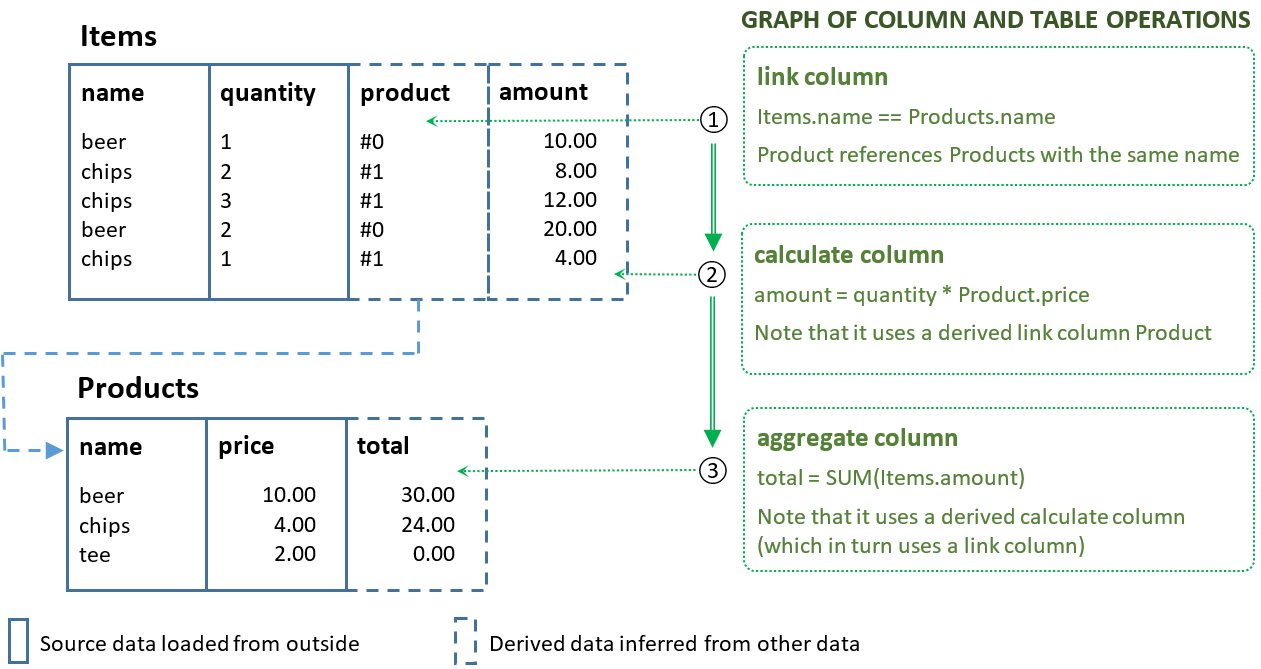

In [10]:
import pandas as pd  # Prosto relies on pandas
import prosto as pr  # Import Prosto toolkit

### Create a new workflow

In [11]:
# Create a workflow
prosto = pr.Prosto("My Prosto Workflow")
# Element name is stored in the id field
print("Workflow name is: ´{}´".format(prosto.id))

Workflow name is: ´My Prosto Workflow´


### Define Items table

This table stores sales data. Each time some product is sold a new record is added to this table.

In [12]:
items_data = {
    'name': ["beer", "chips", "chips", "beer", "chips"],
    'quantity': [1, 2, 3, 2, 1],
}
items_df = pd.DataFrame(data=items_data)

items = prosto.populate(
    # A table definition consists of a name and a list of attributes
    table_name="Items", attributes=["name", "quantity"],

    # Table operation is UDF, input tables and model
    func=lambda **m: items_df, tables=[]
)

items_df.head()

,name,quantity
0,beer,1
1,chips,2
2,chips,3
3,beer,2
4,chips,1


### Define Products table

This table stores a list of products. Note that the list of products is loaded from memory and not generated from any other table in the workflow. In particular, it is not generated from the Items table (this could be done by means of the project operation). Product names should be unique because otherwise the linking will be ambiguous.

In [13]:
products_data = {
    'name': ["beer", "chips", "tee"],
    'price': [10.0, 4.0, 2],
}
products_df = pd.DataFrame(data=products_data)

products = prosto.populate(
    # A table definition consists of a name and a list of attributes
    table_name="Products", attributes=["name", "price"],

    # Table operation is UDF, input tables and model
    func=lambda **m: products_df, tables=[]
)

products_df.head()

,name,price
0,beer,10.0
1,chips,4.0
2,tee,2.0


### Define a link column

A link column stores row ids of some other table. These row ids are interpreted as references and hence it is possible to use these columns in order to access values from other tables.

In our example, the two tables are isolated. A traditional way to use data from multiple tables is to apply join which produces a new table with the necessary data from several source tables. Prosto uses a different approach. Instead of deriving a new table, we attach a new column to an existing table and this new column will reference the necessary raws.

In this example, we want to link `Items` to `Products` by using their name. In other words, an item will reference a product which has the same name. After that, any column in the `Products` table can be used from the `Items` table using a sequence of link column names. For example,  `product::price` can be used to access price for each item.

In [14]:
link_column = prosto.link(
    # In contrast to other columns, a link column specifies its target table name
    name="product", table=items.id, type=products.id,

    # It is a criterion of linking: all input columns have to be equal to the output columns
    columns=["name"], linked_columns=["name"]
)

### Define a calculate column

Now the `Items` table has a `quantity` attribute and `product` link column which provides access to all columns in the `Products` table. Our goal is to compute `amount` using the product of quantity and price. However, since the `price` is located in the linked table, we use the availble link column to access it: `product::price`.

In [15]:
calc_column = prosto.calculate(
    # Column definition consists of a name and a table it belongs to
    name="amount", table=items.id,

    # Column operation is UDF, input columns and model
    func=lambda x: x["quantity"]*x["product::price"], columns=["quantity", "product::price"]
)

### Define an aggregate column

This column belongs to the `Products` table and is treated as a new property computed for each product. Yet, this property is computed using *groups* of records selected in another table, `Items` in our case. More specifically, for each product, we want to select all items (sales transactions) which belong to it via the link column, and then find the sum of their amounts stored in the `amount` column.

In [16]:
total = prosto.aggregate(
    # Column description
    name="total", table=products.id,
    # How to group
    tables=["Items"], link="product",
    # How to aggregate
    func="lambda x: x.sum()", columns=["amount"], model={}
)

### Execute the workflow

Above we provided only definitions. In order to really compute the result, we need to execute the workflow. This operation will build a topology (a graph of table and column operations) and then execute these operations according to their dependencies.

In [17]:
prosto.run()

### Explore the result

Once the workflow has been executed, we can read the result data. 

The expected total amounts are: 

* 30.0 for beer (3 * 10.0)
* 6.0 for chips (6 * 4.0)
* 0.0 for tee because it has no sales records 

In [18]:
table_data = products.get_df()
table_data.head()

,name,price,total
0,beer,10.0,30.0
1,chips,4.0,24.0
2,tee,2.0,0.0


### Summary

* In contrast to traditional set-oriented approaches, we did not use any set operation and no new table was produced. Rather, we applied only column operations which derive new columns from existing data.
* All operations rely on functions in their definition by defining how a new value is computed from input values. The system then determines the logic of application of these functions by implementing the necessary loops.
* Once a column has been defined, it can be re-used in many other operations without the need to embed it again where its results are needed. In particular, link columns are normally heavily used because they materialize the relationships between tables. In SQL, join needs to be specified and computed for each query even though it is the same. In our approach, a link is computed once and then becomes part of the model and can be used in other operations.
* The system automatically tracks all dependencies in the workflow and determines the sequence of execution of operations.